# Data Cleaning/Wrangling for Springboard Capstone Project 1: 
## Prediction of hospital readmission rate for patients with an existing diagnosis based on factors measured at time of intial admission.
The dataset I will be using was originally constructed by researchers at Virginia Commonwealth University to see whether the decision to take a measurement of HbA1c (a test to measure glucose in diabetic patients) during hospitalization led to lower rate of hospital readmission. The HbA1c test is considered by the researchers to be a proxy for a more active management of the diabetes in the patient.  

In this analysis, I will repurpose the data set to perform a correlational analysis/ predictive modeling to determine whether one or more variables are predictive of whether or not a patient will be readmitted to the hospital within 30 days of discharge. Time allowing, the analysis may be extended to see whether prediction of readmission after 30 days can also be predicted.

In [1]:
import pandas as pd
import numpy as np

The data set, ‘Diabetes 130-US hospitals for years 1999-2008 Data Set’ is an open dataset that is obtainable at the UCI Machine Learning repository:
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008# 

In [2]:
file = 'diabetic_data.csv'
df = pd.read_csv(file)

In [55]:
# df.sample with number of rows in parenthesis returns a random sample of values, which may be more informative than the first
# 5 rows as would be returned from df.head()
# set display to show all the columns (tip is from http://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/)
pd.set_option('display.max_columns', 500)
df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit_bin,readmit_tri
17143,63468696,20359539,Caucasian,Male,[80-90),?,3,18,4,14,?,PhysicalMedicineandRehabilitation,44,0,12,0,0,0,V57,808,781,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0
100602,427981160,38304756,Caucasian,Female,[70-80),?,1,6,7,2,CM,?,29,0,6,2,0,1,787,584,276,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0
61520,171744402,102294900,Caucasian,Female,[80-90),?,5,1,1,1,MC,?,47,0,8,1,1,0,250.8,276,401,4,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,0
81749,253829952,33605208,Caucasian,Female,[50-60),?,3,1,1,10,MD,?,54,6,44,0,0,0,414,411,496,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,0,2
19089,68356440,99575703,Caucasian,Male,[50-60),?,2,1,7,4,?,Family/GeneralPractice,69,0,11,0,0,0,427,242,250,5,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30,0,2


In [4]:
# Use df.info() find out the basic parameters of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In addition to finding out that there are 50 variables and 101766 entries, we also find out that none of the columns have non-null values. This could either mean there are no missing values (unlikely) or that the missing values are denoted as either blank or some string (e.g., '?') or numeric (e.g., 0, -1) character.

In [5]:
colnames = df.columns.tolist()

In [6]:
# Function to calculate number of missing values
def per_miss_val(name):
    if name in ['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']:
        return (100*df.loc[:, name][df.loc[:,name]=='?'].count()/df.loc[:,name].count())
    elif name == 'gender':
        return (100*df.loc[:, name][df.loc[:,name]=='Unknown/Invalid'].count()/df.loc[:,name].count())
    else: 
        return 0.0

In [7]:
# Create a list of dictionaries where each column is a dictionary, the key is the column name, the value is a list of values.
records = []
for name in colnames:
    record = {}
  #  print(name) - used during debugging
    record['Feature Name'] = name
    record['List of Unique Values'] = df[name].unique()
    record['# of Unique Values'] = len(df[name].unique())
    record['% Missing Values'] = per_miss_val(name)
    record['First Value'] = df[name].iloc[0]
    records.append(record)
    

In [8]:
pd.set_option('display.max_colwidth', 100) # to be able to inspect a larger fraction of the list of unique values
feature_df = pd.DataFrame(records)
feature_df

,# of Unique Values,% Missing Values,Feature Name,First Value,List of Unique Values
0,101766,0.000000,encounter_id,2278392,"[2278392, 149190, 64410, 500364, 16680, 35754, 55842, 63768, 12522, 15738, 28236, 36900, 40926, ..."
1,71518,0.000000,patient_nbr,8222157,"[8222157, 55629189, 86047875, 82442376, 42519267, 82637451, 84259809, 114882984, 48330783, 63555..."
2,6,2.233555,race,Caucasian,"[Caucasian, AfricanAmerican, ?, Other, Asian, Hispanic]"
3,3,0.002948,gender,Female,"[Female, Male, Unknown/Invalid]"
4,10,0.000000,age,[0-10),"[[0-10), [10-20), [20-30), [30-40), [40-50), [50-60), [60-70), [70-80), [80-90), [90-100)]"
5,10,96.858479,weight,?,"[?, [75-100), [50-75), [0-25), [100-125), [25-50), [125-150), [175-200), [150-175), >200]"
6,8,0.000000,admission_type_id,6,"[6, 1, 2, 3, 4, 5, 8, 7]"
7,26,0.000000,discharge_disposition_id,25,"[25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 13, 12, 16, 17, 22, 23, 9, 20, 15, 24, 28, 19, 27]"
8,17,0.000000,admission_source_id,1,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22, 11, 25, 13]"
9,14,0.000000,time_in_hospital,1,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]"


## Target Column preparation
The target column is 'readmitted'. Initially I will transform the column to binary (0 for 'No' and '>30', 1 for '<30').

Less than 30 days ('<30') is the standard for assessing what constitutes ‘hospital readmission’: CMS defines a hospital readmission as "an admission to an acute care hospital within 30 days of discharge from the same or another acute care hospital."Readmissions-Reduction-Program". www.cms.gov. 2016-02-04. Retrieved 2016-03-01.Also: https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/PhysicianFeedbackProgram/Downloads/2015-ACR-MIF.pdf

This is the criteria that makes sense for the initial mock business case discussed in the proposal.

However, I might want to extend the analysis for practice. A Kaggle competition which used the same data set (a closed competition, so no kernels posted) suggested that the expected output should include '>30' as a separate category (see https://www.kaggle.com/c/diabetes-hospital-readmission#evaluation). I will create a second column to include this as a separate category then decide whether to do multiclass analysis later on if time allows.


In [9]:
df.readmitted.head(15)

0      NO
1     >30
2      NO
3      NO
4      NO
5     >30
6      NO
7     >30
8      NO
9      NO
10    >30
11    <30
12    <30
13     NO
14    >30
Name: readmitted, dtype: object

In [10]:
# Define a function to convert readmitted column to binary
def recode_readmit_bin(readmit_value):
    # Return 1 if readmit_value is '<30'
    if readmit_value == '<30':
        return 1
    # Return 0 if readmit_value is 'NO' or '>30'
    elif (readmit_value == 'NO')  or (readmit_value == '>30'):
        return 0
    # Return np.nan if anything else
    else:
        return np.nan
# Apply the function to the readmitted column and create new column
df['readmit_bin'] = df.readmitted.apply(recode_readmit_bin)
print(df.loc[:15,['readmitted','readmit_bin']])

   readmitted  readmit_bin
0          NO            0
1         >30            0
2          NO            0
3          NO            0
4          NO            0
5         >30            0
6          NO            0
7         >30            0
8          NO            0
9          NO            0
10        >30            0
11        <30            1
12        <30            1
13         NO            0
14        >30            0
15         NO            0


In [11]:
# Define a function to convert readmitted column to three trinary
def recode_readmit_tri(readmit_value):
    # Return 1 if readmit_value is '<30'
    if readmit_value == '<30':
        return 1
    # Return 2 if readmit_value is '>30'
    elif readmit_value == '>30':
        return 2
    # Return 0 if readmit_value is 'NO'
    elif readmit_value == 'NO':
        return 0
    # Return np.nan if anything else
    else: 
        return np.nan

# Aplly the function to the readmitted column and create new column
df['readmit_tri'] = df.readmitted.apply(recode_readmit_tri)
print(df.loc[:15,['readmitted','readmit_bin', 'readmit_tri']])



   readmitted  readmit_bin  readmit_tri
0          NO            0            0
1         >30            0            2
2          NO            0            0
3          NO            0            0
4          NO            0            0
5         >30            0            2
6          NO            0            0
7         >30            0            2
8          NO            0            0
9          NO            0            0
10        >30            0            2
11        <30            1            1
12        <30            1            1
13         NO            0            0
14        >30            0            2
15         NO            0            0


# Missing Values Analysis #

The next table shows only the features with missing values.

In [12]:
feature_missing = feature_df[feature_df["% Missing Values"] > 0]
feature_missing

,# of Unique Values,% Missing Values,Feature Name,First Value,List of Unique Values
2,6,2.233555,race,Caucasian,"[Caucasian, AfricanAmerican, ?, Other, Asian, Hispanic]"
3,3,0.002948,gender,Female,"[Female, Male, Unknown/Invalid]"
5,10,96.858479,weight,?,"[?, [75-100), [50-75), [0-25), [100-125), [25-50), [125-150), [175-200), [150-175), >200]"
10,18,39.557416,payer_code,?,"[?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH, PO, WC, OT, OG, MP, FR]"
11,73,49.082208,medical_specialty,Pediatrics-Endocrinology,"[Pediatrics-Endocrinology, ?, InternalMedicine, Family/GeneralPractice, Cardiology, Surgery-Gene..."
18,717,0.020636,diag_1,250.83,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434, 250.7, 157, 518, 999, 410, 682, 402, 737, 572, V5..."
19,749,0.351787,diag_2,?,"[?, 250.01, 250, 250.43, 157, 411, 492, 427, 198, 403, 288, 998, 507, 174, 425, 456, 401, 715, 4..."
20,790,1.398306,diag_3,?,"[?, 255, V27, 403, 250, V45, 38, 486, 996, 197, 250.6, 427, 627, 414, 416, 714, 428, 582, V43, 2..."


# Analyze each Feature with missing values and decide on a strategy. #
1. Are the missing values randomly distributed?
2. If not, is there something else in the data that the missing values are correlated with?
3. Missing values are identified by '?' in the data set.



# Check for random distribution of missing data #

In [13]:
# What is the % < 30 day readmitted rate for all data including rows with missing values?
df.readmit_bin.sum()/df.readmit_bin.count() * 100

11.159915885462727

In [14]:
# To check whether the data where payer code, medical specialty, diag_1, diag_2, and diag_3
# is missing is randomly distributed, check whether the <30 day readmittance rate
# is the same when those rows are filtered out. 'weight' is not included because it is 97% missing
for i in ['payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3', 'race']:
    print(i, df.readmit_bin[df[i]== '?'].sum()/df.readmit_bin[df[i]== '?'].count()*100)
print('gender', df.readmit_bin[df['gender']== 'Unknown/Invalid'].sum()/df.readmit_bin[df['gender']== 'Unknown/Invalid'].count()*100)

payer_code 11.493938791732909
medical_specialty 11.573805281387015
diag_1 23.809523809523807
diag_2 8.100558659217876
diag_3 6.394940267041462
race 8.271007479102508
gender 0.0


For payer code and medical specialty, both are a pretty similar percentage so that suggests they are randomly distributed.

The % missing values in the diagnoses columns is < 3% and even fewer in the race and gender columns which will affect the accuracy of this measurement but still looks to be not random by this measure.  A t test could be performed to obtain confidence intervals.

Because of the large number of categories in both payer_code and medical_specialty, grouping will need to be performed before running the predictive algorithm.  The fact that missing values appear to be randomly distributed in payer_code and medical_specialty means that payer code and medical specialty can safely be categorized with 'other' when grouping is done.

For race, diag_1, diag_2, and diag_3, other should either be kept separate, dropped, or the mode used.  This decision will be made after EDA is performed.

In [15]:
import matplotlib.pyplot as plt

## Race ##

0    Caucasian
dtype: object

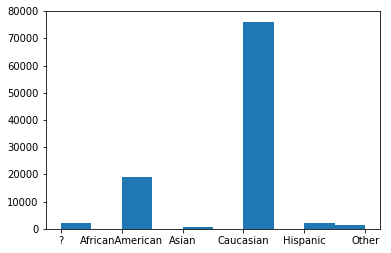

In [16]:
# The most common race is Caucasian, followed by African American.
plt.hist(df.race)
df.race.mode()

In [17]:
# Question: are missing values in race correlated with age group?
for name in colnames:
    if name == 'age':
        age_uniq = list(df[name].unique())

In [18]:
age_uniq

['[0-10)',
 '[10-20)',
 '[20-30)',
 '[30-40)',
 '[40-50)',
 '[50-60)',
 '[60-70)',
 '[70-80)',
 '[80-90)',
 '[90-100)']

In [19]:
miss_dist = []
for age in age_uniq:
    miss_dist.append(len(df[(df.race == '?') & (df.age == age)]))



In [20]:
miss_ser = pd.Series(miss_dist)

In [21]:
# Missing values by age group
miss_ser

0      1
1      9
2     46
3     76
4    220
5    361
6    495
7    599
8    397
9     69
dtype: int64

In [22]:
age_dist = []
for age in age_uniq:
    age_dist.append(len(df[(df.age == age)]))

In [23]:
age_ser = pd.Series(age_dist)

In [24]:
prop = miss_ser/age_ser

In [25]:
prop

0    0.006211
1    0.013025
2    0.027761
3    0.020132
4    0.022716
5    0.020920
6    0.022017
7    0.022978
8    0.023085
9    0.024705
dtype: float64

In [26]:
# Except for the two youngest age groups, the proportion is about the same.  Missing values in race seem to be evenly 
# distributed by age.

## Gender ##

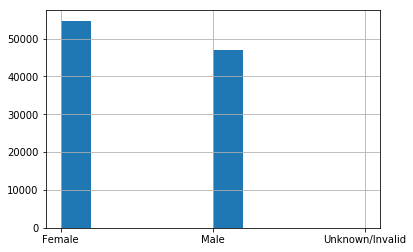

In [27]:
# Tiny percentage of unkown (0.002948%).  Female is the mode.  
df.gender.mode()
df.gender.hist()

## Weight ##

The weight variable is mostly unknown - 97% missing.  I have no reason at this point to believe that it would be crucial to the model so  I've decided to not use this variable in the analysis and remove the column. 

An explanation of why so many values are missing in this column in found in the article describing the original work: “Large percentage of missing values of the weight attribute can be explained by the fact that prior to the HITECH legislation of the American Reinvestment and Recovery Act in 2009 hospitals and clinics were not required to capture it in a structured format.” (https://www.hindawi.com/journals/bmri/2014/781670/)


In [28]:
# Decision: Drop the weight column, rename dataframe to df1
df1 = df.drop('weight',axis=1)

## Payer code ##

The most common value in the payer_code column is '?' or unknown.  However, it was determined earlier that '?' is randomly distributed.  Because of the large number of payer codes, the categorical variables will be grouped before running the predictive algorithm into the top X number plus other.
It would make sense for the missing values be grouped proportionally into the other categorical values based on their frequency.  This will be done at the time that the categorical variables are grouped at the time that the number of groups to use is determined.  This is so we won't have to throw out 1/2 of the data.

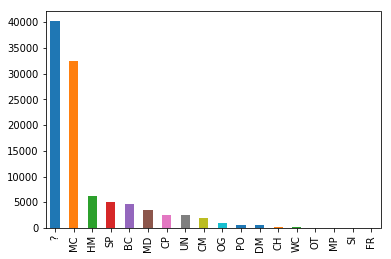

In [29]:
df1.payer_code.value_counts().plot.bar()

MC - which stands for Medicare, is the most common payer code by far.

In [30]:
df1.payer_code.value_counts()[:11]

?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
Name: payer_code, dtype: int64

In [31]:
# Medicare alone accounts for 63% of the non-missing values
(df1.payer_code.value_counts()[1].sum()/df1.medical_specialty.value_counts()[1:].sum())*100

62.60300673524133

In [32]:
#The first 5, non missing payer codes account for 84% of the non missing.
(df1.payer_code.value_counts()[1:6].sum()/df1.payer_code.value_counts()[1:].sum())*100

84.38790440578768

In [33]:
# While the first 10, non missing payer codes account for 98%
(df1.payer_code.value_counts()[1:11].sum()/df1.payer_code.value_counts()[1:].sum())*100

98.276702975126

## Medical Specialty ##
As was the case for payer code, the most common medical specialty in this data set turns out to be unknown.  The next most common is Internal Medicine.

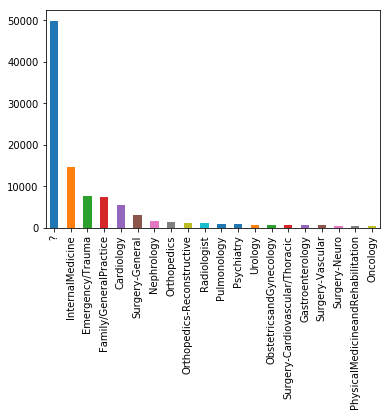

In [34]:
# What is the most common medical specialty besides '?' ? It is Internal Medicine. However, there are a large number of
# unique categories (72).
df1.medical_specialty.value_counts()[:20].plot.bar()

In [35]:
df1.medical_specialty.value_counts()[:11]

?                             49949
InternalMedicine              14635
Emergency/Trauma               7565
Family/GeneralPractice         7440
Cardiology                     5352
Surgery-General                3099
Nephrology                     1613
Orthopedics                    1400
Orthopedics-Reconstructive     1233
Radiologist                    1140
Pulmonology                     871
Name: medical_specialty, dtype: int64

In [36]:
#The first 10, non missing medical specialties account for 86% of the non missing.
(df1.medical_specialty.value_counts()[1:11].sum()/df1.medical_specialty.value_counts()[1:].sum())*100

85.58581160622961

As for payer code, it would make sense for the missing values be grouped proportionally into the other categorical values in the feature based on their frequency. This will be done at the time that the categorical variables are grouped at the time that the number of groups to use is determined.  This is so we won't have to throw out half of the data.

To explore: Is there a way to infer either payer code or medical specialty from some other component of the data set?  For example, if the age group is 0-10, we could infer Pediatrics but not which subspecialty of pediatrics to choose.  Perhaps group all the subspecialties of pediatrics under one Pediatrics category.

## Diagnosis Codes: 1, 2, and 3 ##
Up to three diagnoses can be made for any particular encounter.  The amount of missing values increases from diagnosis 1 to diagnosis 3 as would be expected.  Because there is predictive value to knowing that, for example, there is only one diagnosis, it makes sense to maintain the information that there is no diagnosis rather than either filling or removing the row.
Decision is to replace the '?' with 'none'.

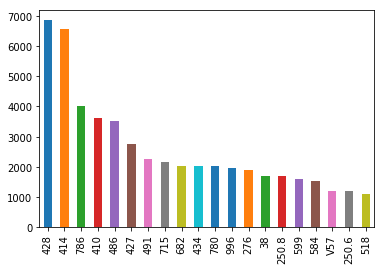

In [37]:
# What is the most common Diagnosis code for Diagnosis 1? It is 428 (heart disease) followed by 414 (ischemic heart disease). 
# In this case there are more than 700 separate codes so grouping will be necessary.
df1.diag_1.value_counts()[:20].plot.bar()

In [38]:
# Except for 786, which stands for 'non-specific or ill-defined symptoms', most of the top diagnoses are related to either heart disease 
# or respiratory ailments.  Significant reduction in the number of categorical values will be possible by binning the 
# values into broader categories according to the ICD-9 coding conventions for disease.  
# See http://www.icd9data.com/2015/Volume1/default.htm for example.
diag_dict = {}
for i in ['diag_1', 'diag_2', 'diag_3']:
    diag_dict[i] = df1[i].value_counts()[:20]
print('Diagnosis 1: ', diag_dict['diag_1'])
print('Diagnosis 2: ', diag_dict['diag_2'])
print('Diagnosis 3: ', diag_dict['diag_3'])       

Diagnosis 1:  428      6862
414      6581
786      4016
410      3614
486      3508
427      2766
491      2275
715      2151
682      2042
434      2028
780      2019
996      1967
276      1889
38       1688
250.8    1680
599      1595
584      1520
V57      1207
250.6    1183
518      1115
Name: diag_1, dtype: int64
Diagnosis 2:  276       6752
428       6662
250       6071
427       5036
401       3736
496       3305
599       3288
403       2823
414       2650
411       2566
250.02    2074
707       1999
585       1871
584       1649
491       1545
250.01    1523
285       1520
780       1491
425       1434
682       1433
Name: diag_2, dtype: int64
Diagnosis 3:  250       11555
401        8289
276        5175
428        4577
427        3955
414        3664
496        2605
403        2357
585        1992
272        1969
599        1941
?          1423
V45        1389
250.02     1369
707        1360
780        1334
285        1200
425        1136
250.6      1080
424        1063
Name

In [39]:
# Check for missing values denoted by a 0 or 1 or other unusual number in encounter_id and patient_nbg
df1.loc[:,['encounter_id', 'patient_nbr']].min()

encounter_id    12522
patient_nbr       135
dtype: int64

Encounter id and patient number appear to not have missing values of this type.

## Data Dictionary ##

To understand each variable better, I created a table showing the Feature Name, Type, and a Description of the feature.

This information was obtained by copy-pasting to Excel the table describing the features located at https://www.hindawi.com/journals/bmri/2014/781670/tab1/ which was included in the paper originally describing the data

In [40]:
data_dictionary = pd.read_csv('diabetes-data-dict2.csv')
data_dictionary.head()

,Feature name,Type,Description and values,% missing
0,Encounter ID,Numeric,Unique identifier of an encounter,0%
1,Patient number,Numeric,Unique identifier of a patient,0%
2,Race,Nominal,"Values: Caucasian, Asian, African American, Hispanic, and other",2%
3,Gender,Nominal,"Values: male, female, and unknown/invalid",0%
4,Age,Nominal,"Grouped in 10-year intervals: 0, 10), 10, 20), â€¦, 90, 100)",0%


In [41]:
# % missing was calculated above so this column can be dropped
data_dictionary = data_dictionary.drop('% missing', axis = 1)

In [42]:
# expand row 26 so each medication is on a separate row
drugs = data_dictionary.iloc[26][2]
drugs

'For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: â€œupâ€\x9d if the dosage was increased during the encounter, â€œdownâ€\x9d if the dosage was decreased, â€œsteadyâ€\x9d if the dosage did not change, and â€œnoâ€\x9d if the drug was not prescribed'

In [43]:
# import regex library
import re

In [44]:
drug_list = re.compile('For the generic names: (.+?), the').findall(drugs)

In [45]:
drug_list2 = drug_list[0].split(', ')

In [46]:
drug_list2

['metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'sitagliptin',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'and metformin-pioglitazone']

In [47]:
drug_list2[-1] = 'metformin-pioglitazone'

In [48]:
#Create a dataframe with the drug names

df_drug = pd.DataFrame(drug_list2, columns = ["Feature name"])
df_drug.head()

,Feature name
0,metformin
1,repaglinide
2,nateglinide
3,chlorpropamide
4,glimepiride


In [49]:
# Add the description of the Feature name for each drug
drugs_desc = "the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed"

In [50]:
df_drug['Description and values'] = drugs_desc
df_drug['Type'] = 'Nominal'
df_drug.head()

,Feature name,Description and values,Type
0,metformin,the feature indicates whether the drug was prescribed or there was a change in the dosage. Value...,Nominal
1,repaglinide,the feature indicates whether the drug was prescribed or there was a change in the dosage. Value...,Nominal
2,nateglinide,the feature indicates whether the drug was prescribed or there was a change in the dosage. Value...,Nominal
3,chlorpropamide,the feature indicates whether the drug was prescribed or there was a change in the dosage. Value...,Nominal
4,glimepiride,the feature indicates whether the drug was prescribed or there was a change in the dosage. Value...,Nominal


In [51]:
data_dictionary = pd.concat([data_dictionary.iloc[:26,:],df_drug, data_dictionary.iloc[27:]], ignore_index=True)

In [52]:
# Question: How do I format the table to show the full description of the Feature (first column above)?
# Answer: The following option allows for all the text to be displayed.  
# This is from http://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_colwidth', -1)
# setting the text to left justify is not a simple option in set_option so I'm leaving it this way for now
data_dictionary

,Description and values,Feature name,Type
0,Unique identifier of an encounter,Encounter ID,Numeric
1,Unique identifier of a patient,Patient number,Numeric
2,"Values: Caucasian, Asian, African American, Hispanic, and other",Race,Nominal
3,"Values: male, female, and unknown/invalid",Gender,Nominal
4,"Grouped in 10-year intervals: 0, 10), 10, 20), â€¦, 90, 100)",Age,Nominal
5,Weight in pounds.,Weight,Numeric
6,"Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available",Admission type,Nominal
7,"Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available",Discharge disposition,Nominal
8,"Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital",Admission source,Nominal
9,Integer number of days between admission and discharge,Time in hospital,Numeric
